# Project Part 1

####  Owen McGrattan 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# import datasets 
ny = pd.read_csv('./bikeshare/ny.csv')
chi = pd.read_csv('./bikeshare/chicago.csv')
dc = pd.read_csv('./bikeshare/dc.csv')
day = pd.read_csv('./bikeshare/day.csv')

# 1. Preliminary Data Analysis

# 1.1 Demographic Information

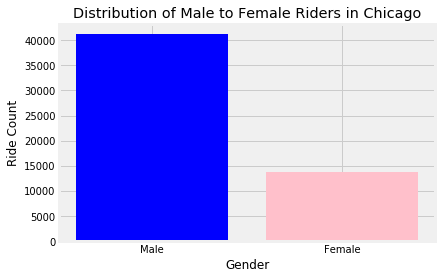

In [3]:
# plot dist of male to female riders in chi
plt.bar(chi['gender'].dropna().unique(), [len(chi[chi['gender'] == 'Male']), len(chi[chi['gender'] == 'Female'])], color = ['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Ride Count')
plt.title('Distribution of Male to Female Riders in Chicago')
plt.show()

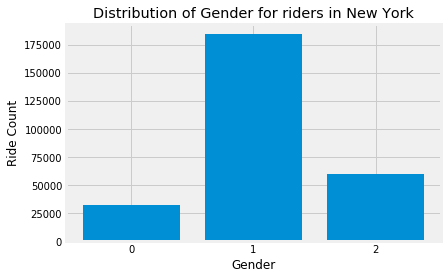

In [4]:
# plot male to female riders in ny 
plt.bar(['0', '1', '2'], [len(ny[ny['gender'] == 0]), len(ny[ny['gender'] == 1]), len(ny[ny['gender'] == 2])])
plt.xlabel('Gender')
plt.ylabel('Ride Count')
plt.title('Distribution of Gender for riders in New York')
plt.show()

In [5]:
# before we make assumptions about how this gender variable was assigned, let's check the na count for chi
print(len(chi[chi['gender'] == 'Female']))
print(len(chi[chi['gender'].isna()]))


13783
17154


In [6]:
# assign ny gender 
ny.loc[ny['gender'] == 0, 'gender'] = 'Female'
ny.loc[ny['gender'] == 1, 'gender'] = 'Male'
ny.loc[ny['gender'] == 2, 'gender'] = 'Unspecified'

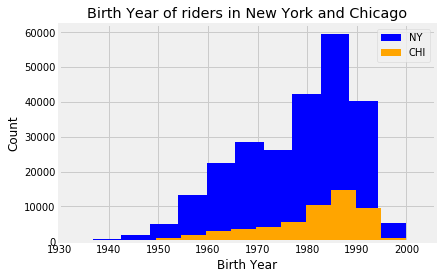

In [7]:
plt.hist(ny['birth year'].dropna(), color = 'blue', label = 'NY', bins = 20 )
plt.hist(chi['birthyear'].dropna(), color = 'orange', label = 'CHI', bins = 20)
plt.xlabel('Birth Year')
plt.ylabel('Count')
plt.xlim(left = 1930)
plt.title('Birth Year of riders in New York and Chicago')
plt.legend()

In [8]:
print(len(ny['birth year'].dropna()), len(ny) - len(ny['birth year'].dropna()))
print(len(chi['birthyear'].dropna()), len(chi) - len(chi['birthyear'].dropna()))

245137 31661
54986 17145


The distribution of birth years makes sense given we're talking about scooter usage.  We should expect heavy amounts of usage from younger folks but I'll admit I did not expect this range of scooter usage from people of all ages.  I did limit my graph to being anything pertaining to 1930 or later.  There necessarily isn't any data that I'd like to drop right now as the number of riders without birth year data can be quite high relative to the total number of riders in a given set.

# 1.2 Rental Times

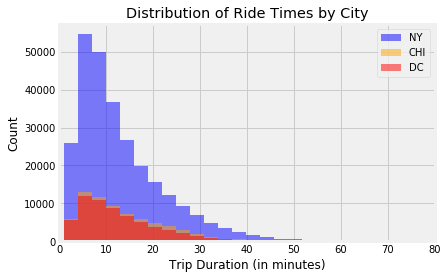

In [9]:
plt.hist(ny[(ny['tripduration'] / 60) < 300]['tripduration'] / 60, color = 'blue', label = 'NY', bins = 100, alpha = 0.5)
plt.hist(chi[(chi['tripduration'] / 60) < 300]['tripduration'] / 60, color = 'orange', label = 'CHI', bins = 100, alpha = 0.5)
plt.hist(dc[(dc['Duration (ms)'] / 60000) < 300]['Duration (ms)'] / 60000, color = 'red', label = 'DC', bins = 100, alpha = 0.5)
plt.xlabel('Trip Duration (in minutes)')
plt.ylabel('Count')
plt.title('Distribution of Ride Times by City')
plt.legend()
plt.xlim(right = 80, left = 0)
plt.show()

The size of our NY dataset here has almost outsized the CHI and DC data so let's take a look at a density plot instead.

/Users/owenmcgrattan/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


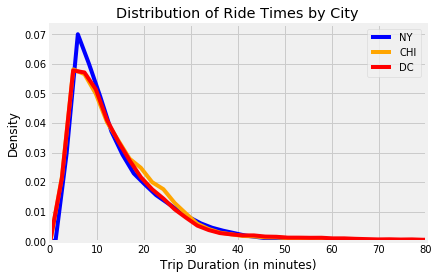

In [10]:
sns.distplot(ny[(ny['tripduration'] / 60) < 300]['tripduration'] / 60, color = 'blue', label = 'NY', bins = 100, hist = False, )
sns.distplot(chi[(chi['tripduration'] / 60) < 300]['tripduration'] / 60, color = 'orange', label = 'CHI', bins = 100, hist = False)
sns.distplot(dc[(dc['Duration (ms)'] / 60000) < 300]['Duration (ms)'] / 60000, color = 'red', label = 'DC', bins = 100, hist = False)
plt.xlabel('Trip Duration (in minutes)')
plt.ylabel('Density')
plt.title('Distribution of Ride Times by City')
plt.legend()
plt.xlim(right = 80, left = 0)
plt.show()

We get to see something of a more comparable image, namely that the NY, CHI, and DC distributions are quite similar to one another.  

In [11]:
# we need to set ny, chi, dc times to datetime objects
dc['Start date'] = pd.to_datetime(dc['Start date'], format = "%m/%d/%Y %H:%M")
ny['starttime'] = pd.to_datetime(ny['starttime'])
chi['starttime'] = pd.to_datetime(chi['starttime'])

# store hours for each city in arrays
dc_hours = np.array([x.hour for x in dc['Start date']])
ny_hours = np.array([x.hour for x in ny['starttime']])
chi_hours = np.array([x.hour for x in chi['starttime']])

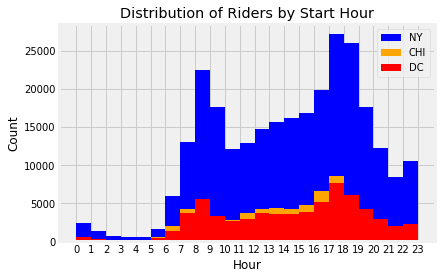

In [12]:
plt.hist(ny_hours, bins = 23, color = 'blue', label = 'NY')
plt.hist(chi_hours, bins = 23, color = 'orange', label = 'CHI')
plt.hist(dc_hours, bins = 23, color = 'red', label = 'DC')
plt.xticks(np.unique(dc_hours))
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Distribution of Riders by Start Hour')
plt.legend()
plt.show()

The two biggest peaks we observe occur when people are either commuting to or leaving from work.  In between the start of the workday and end of the work day there is a steady increase before an explosion at the end of the work day.  There is certainly a greater share of workers riding after work than going to work.  

I wasn't necessarily sure that I would expect such a higher peak at the end of the work day and I'm not sure if my intuition makes sense or is necessary in this case.  I would imagine that there are more people at the end of the day who are not going home as opposed to those riders in the morning who are almost assuredly making a commute.  In this instance I think it would useful to compare ride times between morning and evening as well as for individual users checking the number of start and end stations from the morning that match the evening.

# 1.3 Further Exploration

In [13]:
ny['start_hour'] = ny_hours

/Users/owenmcgrattan/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


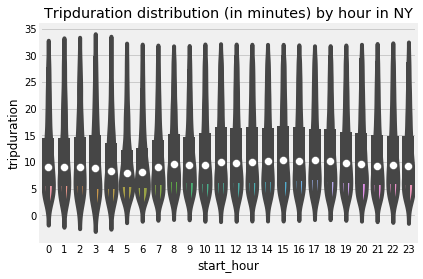

In [14]:
# trip durations by hour
sns.violinplot(x = 'start_hour', y = ny['tripduration'] / 60, data = ny[(ny['tripduration'] / 60) <= 30] )
plt.title('Tripduration distribution (in minutes) by hour in NY')
plt.show()

/Users/owenmcgrattan/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


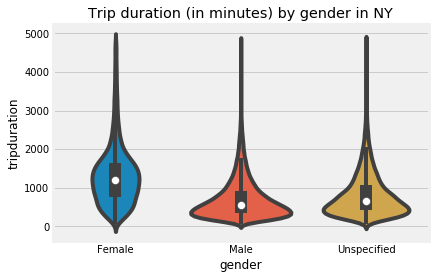

In [15]:
# trip duration by gender 
sns.violinplot(x = 'gender', y = ny['tripduration'], data = ny[(ny['tripduration'] / 60) < 80])
plt.title('Trip duration (in minutes) by gender in NY')
plt.show()

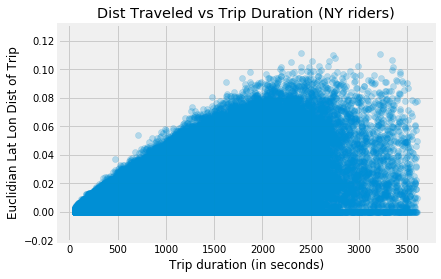

In [16]:
# create variable for day of the year 
ny['lat_lon_dist'] = np.sqrt((ny['start station longitude'] - ny['end station longitude'])**2 + (ny['start station latitude'] - ny['end station latitude'])**2)

plt.scatter('tripduration', 'lat_lon_dist', data = ny[((ny['tripduration'] / 60) <= 60) & (ny['lat_lon_dist'] < 0.15)], alpha = 0.25)

plt.xlabel('Trip duration (in seconds)')
plt.ylabel('Euclidian Lat Lon Dist of Trip')
plt.title('Dist Traveled vs Trip Duration (NY riders)')
plt.show()

I wanted to go in and get a little more sense as to some of the distributions especially regarding information on trip durations.  

In the first plot we can see that the trip duration doesn't vary much as a function of start hour which was slightly surprising to me.  I was expecting drastically different distributions, or at least certainly higher ones for the morning and midday, but the average for each of them is largely within the same 2-3 minute band around 10 minutes.  

Next I looked at what was I thought more of a shot in the dark in looking at trip duration distributions by gender and I was surprised to see such a difference between the female and other gender groups.  And it isn't in just the means but the shape of the distributions as well.  Both the male and unspecified distributions exhibit a much stronger skew than the female distribution.

I also wanted to see if trip duration was linearly related with a rough measure of distance which in this case I chose euclidian lat lon distance.  I should have assumed before I went through with creating this that there would be riders who ultimately leave and come back to the same station so many of the measures would be fairly invalid.  But at the top of scatterplot we can see a highly linear relationship which seems to give us an upperbound as to how far someone can get in a given amount of time. 

It would be beneficial to run back through the differences between the male and female trip duration distributions, possibly running the E-M algorithm or running Benjamini-Hochberg on a logistic regression model predicting the gender of a given rider.

# 1.4 Creating a new Dataset

To transform our NY, DC, and CHI datasets into something that looks like our day dataset we'll need to do some transformations of our date variables and aggregate based on the calendar date.  We can recreate the same format as the day dataframe just without the weather related variables.

In [17]:
# we are transforming or grouping on each day 
# we'll operate on copied dataframes for each of the different tables 
ny_copy = ny
dc_copy = dc
chi_copy = chi

In [18]:
ny_copy['dteday'] = np.array([ny_copy['starttime'][i].date() for i in range(len(ny_copy))])
dc_copy['dteday'] = np.array([dc_copy['Start date'][i].date() for i in range(len(dc_copy))])
chi_copy['dteday'] = np.array([chi_copy['starttime'][i].date() for i in range(len(chi_copy))])


ny_copy['registered'] = np.array([1 if i == 'Subscriber' else 0 for i in ny_copy['usertype']])
chi_copy['registered'] = np.array([1 if i == 'Subscriber' else 0 for i in chi_copy['usertype']])
dc_copy['registered'] = np.array([1 if i == 'Registered' else 0 for i in dc_copy['Member Type']])

ny_copy['casual'] = np.array([1 if ny_copy['registered'][i] == 0 else 0 for i in range(len(ny_copy))])
chi_copy['casual'] = np.array([1 if chi_copy['registered'][i] == 0 else 0 for i in range(len(chi_copy))])
dc_copy['casual'] = np.array([1 if dc_copy['registered'][i] == 0 else 0 for i in range(len(dc_copy))])

In [19]:
ny_copy = ny_copy[['dteday',  'registered', 'casual']]
chi_copy = chi_copy[[ 'dteday',  'registered', 'casual']]
dc_copy = dc_copy[['dteday',  'registered', 'casual']]

ny_daily = ny_copy.groupby('dteday')[['registered', 'casual']].sum()
chi_daily = chi_copy.groupby('dteday')[['registered', 'casual']].sum()
dc_daily = dc_copy.groupby('dteday')[['registered', 'casual']].sum()

ny_daily = ny_daily.reset_index()
chi_daily = chi_daily.reset_index()
dc_daily = dc_daily.reset_index()

In [20]:
ny_daily['weekday'] = np.array([ny_daily['dteday'][i].weekday() for i in range(len(ny_daily))])
dc_daily['weekday'] = np.array([dc_daily['dteday'][i].weekday() for i in range(len(dc_daily))])
chi_daily['weekday'] = np.array([chi_daily['dteday'][i].weekday() for i in range(len(chi_daily))])

ny_daily['mnth'] = np.array([ny_copy['dteday'][i].month for i in range(len(ny_daily))])
dc_daily['mnth'] = np.array([dc_copy['dteday'][i].month for i in range(len(dc_daily))])
chi_daily['mnth'] = np.array([chi_copy['dteday'][i].month for i in range(len(chi_daily))])

ny_daily['cnt'] = ny_daily['casual'] + ny_daily['registered']
chi_daily['cnt'] = chi_daily['casual'] + chi_daily['registered']
dc_daily['cnt'] = dc_daily['casual'] + dc_daily['registered']

In [21]:
holidays = [datetime.date(2016, 1, 1), datetime.date(2016, 1, 18), datetime.date(2016, 5, 30), datetime.date(2016, 7, 4),
           datetime.date(2016, 9, 5), datetime.date(2016, 11, 11), datetime.date(2016, 11, 24), datetime.date(2016, 12, 25)]

ny_daily['holiday'] = np.array([1 if ny_daily['dteday'][i] in holidays else 0 for i in range(len(ny_daily))])
chi_daily['holiday'] = np.array([1 if chi_daily['dteday'][i] in holidays else 0 for i in range(len(chi_daily))])
dc_daily['holiday'] = np.array([1 if dc_daily['dteday'][i] in holidays else 0 for i in range(len(dc_daily))])

weekday = [5, 6]
ny_daily['workingday'] = np.array([0 if (ny_daily['holiday'][i] == 1 or ny_daily['weekday'][i] in weekday) else 1 for i in range(len(ny_daily))])
chi_daily['workingday'] = np.array([0 if (chi_daily['holiday'][i] == 1 or chi_daily['weekday'][i] in weekday) else 1 for i in range(len(chi_daily))])
dc_daily['workingday'] = np.array([0 if (dc_daily['holiday'][i] == 1 or dc_daily['weekday'][i] in weekday) else 1 for i in range(len(dc_daily))])

For creating these sets I wanted to make sure that I had each of the date values in datetime format before going any further.  It made everything easier going forward especially once it came time to group the whole set by day.  Similarly creating binary encodings for registered and casual riders made things far easier as well.  The only concerns really came from how I was going to encode the holiday values since holidays like Thanksgiving do not fall on the same date each year.  However after some quick searching through the unique dates for each of the NY, DC, and CHI sets revealed that 2016 was the only year encompassed so I simply took a set of the 2016 holiday dates.  Once the holidays were encoded for I was able to pair that information as well as the datetime encoded weekday value to find our working days.

In [53]:
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


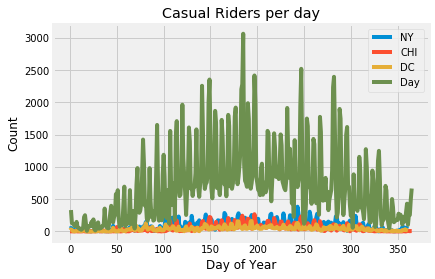

In [61]:
plt.plot(ny_daily.index, ny_daily['casual'], label = 'NY')
plt.plot(chi_daily.index, chi_daily['casual'], label = 'CHI')
plt.plot(dc_daily.index, dc_daily['casual'], label = 'DC')
plt.plot(day[day['instant'] < 366]['instant'], day[day['instant'] < 366]['casual'], label = 'Day')
plt.xlabel('Day of Year')
plt.ylabel('Count')
plt.title('Casual Riders per day')
plt.legend()
plt.show()

In [64]:
day['instant'].max()

731

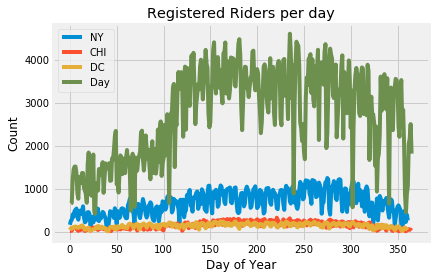

In [66]:
plt.plot(ny_daily.index, ny_daily['registered'], label = 'NY')
plt.plot(chi_daily.index, chi_daily['registered'], label = 'CHI')
plt.plot(dc_daily.index, dc_daily['registered'], label = 'DC')
plt.plot(day[day['instant'] < 366]['instant'], day[day['instant'] < 366]['registered'], label = 'Day')
plt.xlabel('Day of Year')
plt.ylabel('Count')
plt.title('Registered Riders per day')
plt.legend()
plt.show()

Even with a rough imbalance between the overall counts we can still pull apart the main trend that rider counts, both registered and casual, tend to rise a significant portion in the summer months.  And not that we have it but it'd be highly beneficial to add weather data to our city datasets and try and test the validity of the impacts that weather appears to have on rider counts.  But just to get a better sense of our city sets let's look at them in isolation.

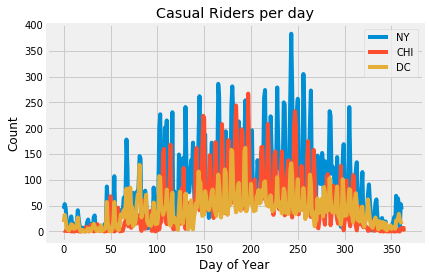

In [68]:
plt.plot(ny_daily.index, ny_daily['casual'], label = 'NY')
plt.plot(chi_daily.index, chi_daily['casual'], label = 'CHI')
plt.plot(dc_daily.index, dc_daily['casual'], label = 'DC')
plt.xlabel('Day of Year')
plt.ylabel('Count')
plt.title('Casual Riders per day')
plt.legend()
plt.show()

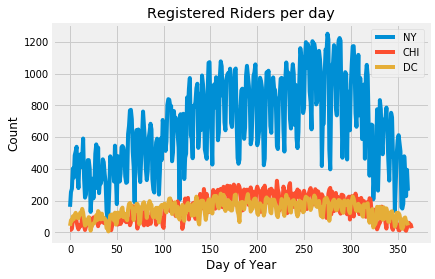

In [69]:
plt.plot(ny_daily.index, ny_daily['registered'], label = 'NY')
plt.plot(chi_daily.index, chi_daily['registered'], label = 'CHI')
plt.plot(dc_daily.index, dc_daily['registered'], label = 'DC')
plt.xlabel('Day of Year')
plt.ylabel('Count')
plt.title('Registered Riders per day')
plt.legend()
plt.show()

We observe similar slopes for each of the cities throughout the year but what's more stark here is the number of casual riders in NY being in line with other cities while the number of registered users in NY just towers over everything else.

# 2. Hypothesis Testing

In [22]:
# filter set to our desired variables, create start and stop hours

chi_lr = chi[['usertype', 'starttime', 'stoptime', 'tripduration']].dropna()
chi_lr['starttime'] = pd.to_datetime(chi_lr['starttime'])
chi_lr['stoptime'] = pd.to_datetime(chi_lr['stoptime'])

chi_lr['start_hour'] = np.array([x.hour for x in chi_lr['starttime']])
chi_lr['stop_hour'] = np.array([x.hour for x in chi_lr['stoptime']])

# create binary encoding for our respone variable, casual v non-casual
chi_lr['sub'] = [1 if i == 'Subscriber' else 0 for i in chi_lr['usertype']]
chi_lr = chi_lr[['start_hour', 'stop_hour', 'tripduration', 'sub']]
chi_lr = chi_lr[:(len(chi_lr) - 1)]

In [23]:
# create our s1, s2, and s3 sets

s_1, s_3, y_1, y_3 = train_test_split(chi_lr.drop(columns = 'sub'), chi_lr['sub'], test_size = 0.2)
s_1, s_2, y_1, y_2 = train_test_split(s_1, y_1, test_size = 0.25)

In [24]:
# fit our model
s1 = LogisticRegression()
s1.fit(s_1, y_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
s2 = s1.predict_proba(s_2)[:, 1]
s3 = s1.predict_proba(s_3)[:, 1]

In [26]:
s2_0 = s_2[y_2 == 0]
# loop through and create p_values for s_3
p_vals = []
for j in range(len(s3)):
    p_vals.append((1 / len(s2_0)) * len(s_2[(y_2 == 0) & (s2 > s3[j])]))

s_3['p_vals'] = p_vals
p_vals = np.array(p_vals)

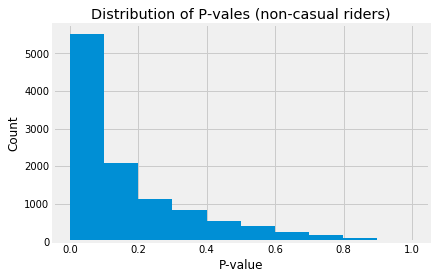

In [27]:
plt.hist(s_3[y_3 == 1]['p_vals'], label = 'non-casual')
plt.xlabel('P-value')
plt.ylabel('Count')
plt.title('Distribution of P-vales (non-casual riders)')
plt.show()

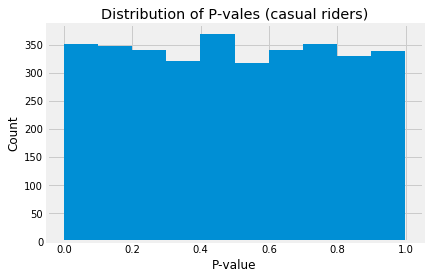

In [28]:

plt.hist(s_3[y_3 == 0]['p_vals'], label = 'casual rider')
plt.xlabel('P-value')
plt.ylabel('Count')
plt.title('Distribution of P-vales (casual riders)')
plt.show()

We see that the distribution of our p-values for our casual set are somewhat uniformly distributed with the overwhelming majority being above the standard 0.05 threshold wheras the large proportion of of our non-casual set are below the 0.05 threshold.

In [29]:
 def benjamini_hochberg(p_values, alpha):
    # returns decisions: a binary vector of the same length as p-values, 
    # where decisions[i] is 1 if p_values[i] is deemed significant at level alpha, and 0 otherwize
    
    n = len(p_values)
    
    # get the idxs which will sorted the p-values in ascending order
    sorted_idxs = np.argsort(p_values)
    sorted_p_values = p_values[sorted_idxs]
    # find the largest k for which p_values[k] < k/n * alpha
    
    #  instantiate vector for k/n * alpha
    comparison = np.arange(1, n+1) * alpha / n
    
    # find the largest k such that p value falls below the comparison line
    # add one for zero indexing
    k = np.argmax(np.where(sorted_p_values <= comparison))
    
    # declare a discovery for anything with p-value <= the k^th p-value
    p_k = sorted_p_values[k]
    
    # instantiate decisions
    decisions = (p_values <= p_k).astype(int)
    
    # return decisions
    return decisions
    

def print_confusion_matrix(res_dict):
    # This is a helper function to print the confusion matrix. You don't need to modify this code.
    results_df = pd.DataFrame(data = {"Decision = 0": [res_dict['TN_count'], res_dict['FN_count']], 
                                      "Decision = 1":  [res_dict['FP_count'], res_dict['TP_count']]},
                             index=["Truth = 0", "Truth = 1"])
    print(results_df)


def report_results(predicted_discoveries, truth):
    # input: predicted discoveries: n-dimensional array of 0/1 values where 1 indicates a "discovery"
    #        truth: n-dimensional array of 0/1 values where 1 indicates a draw from the altertanative
    
    
    # populate the following dictionary with COUNTS:
    # TODO: fill in each of these counts
    TP_count = np.sum( predicted_discoveries & truth)
    TN_count = np.sum( (1 - predicted_discoveries) & (1 - truth))
    FP_count = np.sum( predicted_discoveries & (1 - truth))
    FN_count = np.sum( (1 - predicted_discoveries) & truth)
    
    results_dictionary = {"TN_count": TN_count,
                          "TP_count": TP_count,
                          "FN_count": FN_count,
                          "FP_count": FP_count,
                         }
    
    # this function is defined for you below
    #cprint_confusion_matrix(results_dictionary)
    return results_dictionary

def print_false_discovery_fraction(results_dictionary):
    total_predicted_discoveries = results_dictionary['FP_count'] + results_dictionary['TP_count']
    false_predicted_discoveries = results_dictionary['FP_count'] 
    
    # TODO: fill in - compute the false discovery fraction from the results dictionary
    false_discovery_frac = false_predicted_discoveries / total_predicted_discoveries
    
    #print("total discoveries: {0}".format(total_predicted_discoveries))
    #print("fraction of discoveries which were actually false: {0:.3f}".format(false_discovery_frac))
    return total_predicted_discoveries, false_discovery_frac




In [30]:

alpha = 0.2
bh_decisions = benjamini_hochberg(p_vals, alpha)

bh_results = report_results(bh_decisions,y_3)

print_false_discovery_fraction(bh_results)

(4378, 0.05047967108268616)

In [31]:
# now run 200 different times and report avg fdp
fdps = []
for i in range(50):
    s_1, s_3, y_1, y_3 = train_test_split(chi_lr.drop(columns = 'sub'), chi_lr['sub'], test_size = 0.2)
    s_1, s_2, y_1, y_2 = train_test_split(s_1, y_1, test_size = 0.25)
    
    s1 = LogisticRegression()
    s1.fit(s_1, y_1)
    
    s2 = s1.predict_proba(s_2)[:, 1]
    s3 = s1.predict_proba(s_3)[:, 1]
    
    s2_0 = s_2[y_2 == 0]
    # loop through and create p_values for s_3
    p_vals = []
    for j in range(len(s3)):
        p_vals.append((1 / len(s2_0)) * len(s_2[(y_2 == 0) & (s2 > s3[j])]))

    s_3['p_vals'] = p_vals
    p_vals = np.array(p_vals)
    
    alpha = 0.2
    bh_decisions = benjamini_hochberg(p_vals, alpha)

    bh_results = report_results(bh_decisions,y_3)

    fdps.append(print_false_discovery_fraction(bh_results)[1])

np.mean(fdps)

0.045737798637920504

Our FDP stayed below 0.05 similarly to our section above when we only ran benjamini-hochberg once.  This is in part due to our alpha leading us to very conservatively declare discoveries.  Were we to tweak our alpha we could get a better sense of FDR under a more aggresive setting.

# 3. Gaussian Mixture Models of Trip Durations

1. We presume the subscribers to use scooters on their commutes, for what should be shorter periods of time.  Non-subscribers on the other hand are likely sightseeing, traveling a far distance, or some other travel that is a more extreme period of time.  

/Users/owenmcgrattan/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


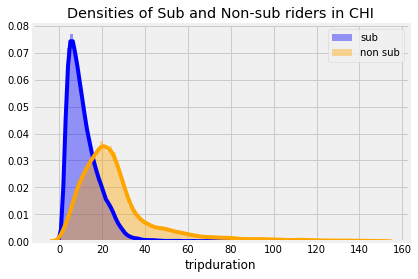

In [33]:
sns.distplot(chi[((chi['tripduration'] / 60) < 150) & (chi['usertype'] == 'Subscriber')]['tripduration'] / 60, color = 'blue', label = 'sub', bins = 100)
sns.distplot(chi[((chi['tripduration'] / 60) < 150) & (chi['usertype'] != 'Subscriber')]['tripduration'] / 60, color = 'orange', label = 'non sub', bins = 100)
plt.legend()
plt.title('Densities of Sub and Non-sub riders in CHI')
plt.show()

In [34]:
def gmm_expectation_maximization(data, pi_0, mu_0, pi_1, mu_1, num_steps):
    """ Perform expectation maximization assuming a Gaussian mixture model consisting of two Gaussians.
    
    Parameters
    ----------
    data : numpy array of shape n
        The matrix of datapoints we've observed.
    pi_0 : float
        Our initial estimate of pi_0.
    mu_0 : float
        Our initial estimate of mu_0.
    pi_1 : float
        Our initial estimate of pi_1.
    mu_1 : float
        Our initial estimate of mu_1.
    num_steps : int
        The number of times to run the expectation maximization.
    """
    for step in range(num_steps):
        # First run the expectation step.
        gaussian_prob_0 = (np.exp(-(data - mu_0) ** 2 / (2 * sigma_0)) /
                           (np.sqrt(2 * np.pi) * sigma_0))
        gaussian_prob_1 = (np.exp(-(data - mu_1) ** 2 / (2 * sigma_1)) /
                           (np.sqrt(2 * np.pi) * sigma_1))
        normalizing_factor = pi_0 * gaussian_prob_0 + pi_1 * gaussian_prob_1
        # z_k is the vector of estimated probabilities that each datapoint i
        # belongs to the distribution k. In other words the ith index is an
        # estimate of P(K=k|x_i).
        z_0 = pi_0 * gaussian_prob_0 / normalizing_factor
        z_1 = pi_1 * gaussian_prob_1 / normalizing_factor
        
        # Now run the maximization step.
        # N_k is the estimated number of points assigned to the distribution k.
        N_0 = np.sum(z_0)
        N_1 = np.sum(z_1)
        pi_0 = N_0 / data.shape[0]
        pi_1 = N_1 / data.shape[0]
        mu_0 = np.sum(data * z_0) / N_0
        mu_1 = np.sum(data * z_1) / N_1
        
    return pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1

In [35]:
print(len(chi[chi['usertype'] == 'Subscriber']) / len(chi))
print(len(chi[chi['usertype'] != 'Subscriber']) / len(chi))

0.7622520136973008
0.23774798630269925


In [36]:
times = chi[(chi['tripduration'] / 60) <= 60]['tripduration'] / 60
sigma_0 = 7.5
sigma_1 = 5.5
pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1 = gmm_expectation_maximization(data=times,
                                                                        pi_0= .25,
                                                                        mu_0= 20,
                                                                        pi_1= .75,
                                                                        mu_1= 7,
                                                                        num_steps=100)
# Print the estimated parameters for both distributions.
print("---Distribution 0 Estimated Parameters---")
print("pi_0={:.4f}, mu_0={:.2f}, sigma_0={:.2f}".format(pi_0, mu_0, sigma_0))
print("---Distribution 1 Estimated Parameters---")
print("pi_1={:.4f}, mu_1={:.2f}, sigma_1={:.2f}".format(pi_1, mu_1, sigma_1))

---Distribution 0 Estimated Parameters---
pi_0=0.2945, mu_0=26.11, sigma_0=7.50
---Distribution 1 Estimated Parameters---
pi_1=0.7055, mu_1=8.91, sigma_1=5.50


In [37]:
pi0s = []
pi1s = []
mu0s = []
mu1s = []
sigma0s = []
sigma1s = []

m0s = [5, 10, 10.5, 20]
m1s = [1, 8, 10, 7]
p0s = [0.1, 0.25, 0.5, 0.55]
p1s = [0.7, 0.75, 0.5, 0.45]

# iterate through different initializations and collect pis and mus
for i in range(4):
    pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1 = gmm_expectation_maximization(data=times,
                                                                        pi_0= p0s[i],
                                                                        mu_0= m0s[i],
                                                                        pi_1= p1s[i],
                                                                        mu_1= m1s[i],
                                                                        num_steps=20)
    pi0s.append(pi_0)
    pi1s.append(pi_1)
    mu0s.append(mu_0)
    mu1s.append(mu_1)
    sigma0s.append(sigma_0)
    sigma1s.append(sigma_1)

In [38]:
print("Non-subscriber means: " + str(mu0s))

print(" ")

print("Non-subscriber proportions: " + str(pi0s))

print(" ")

print("Subscriber proportions: " + str(pi1s))

print(" ")

print("Subscriber means: " + str(mu1s))

Non-subscriber means: [26.10415607187461, 26.10469264724439, 26.10453769895311, 26.104825742869604]
 
Non-subscriber proportions: [0.29451718823165024, 0.2944993820853313, 0.29450452392483334, 0.2944949654671042]
 
Subscriber proportions: [0.7054828117683496, 0.7055006179146688, 0.7054954760751667, 0.7055050345328957]
 
Subscriber means: [8.909228793150083, 8.909438791940254, 8.90937815049858, 8.909490880696882]


We can see that our mus and sigmas are pretty robust so long as the initialization conveys that the non-subscriber mean is any bit higher than the subscriber mean.  Even tweaking around with lower numbers of steps still results in quick convergence.  Tweaking the class proportions doesn't alter much either, even to the point of initializing with a higher base of non-subscribers. 

In [39]:
# we'll run one more time to come down with finite values
pi_0, mu_0, sigma_0, pi_1, mu_1, sigma_1 = gmm_expectation_maximization(data=times,
                                                                        pi_0= .29,
                                                                        mu_0= 26,
                                                                        pi_1= .70,
                                                                        mu_1= 8.9,
                                                                        num_steps=100)

# calculate posterior probability 

gaussian_prob_0 = (np.exp(-(times - mu_0) ** 2 / (2 * sigma_0)) /
                           (np.sqrt(2 * np.pi) * sigma_0))
gaussian_prob_1 = (np.exp(-(times - mu_1) ** 2 / (2 * sigma_1)) /
                           (np.sqrt(2 * np.pi) * sigma_1))
normalizing_factor = pi_0 * gaussian_prob_0 + pi_1 * gaussian_prob_1

z_0 = pi_0 * gaussian_prob_0 / normalizing_factor # prob of class zero
z_1 = pi_1 * gaussian_prob_1 / normalizing_factor # prob of class one

In [40]:
sub_pred = np.array([1 if z_1[i] >= 0.5 else 0 for i in z_1.index])
actual = np.array([1 if chi['usertype'][i] == 'Subscriber' else 0 for i in range(len(z_1))])
acc = np.mean(sub_pred == actual)
acc

0.6185445843186678

In [41]:
# run classifier on ny and dc sets 
ny_times = ny[(ny['tripduration'] / 60) <= 60]['tripduration'] / 60
dc_times = dc[(dc['Duration (ms)'] / 60000) <= 60]['Duration (ms)'] / 60000
dat = [ny_times, dc_times]
actuals = [ny['usertype'], dc['Member Type']]
subs = ['Subscriber', 'Registered']
accs = []

for j in range(len(dat)):
    gaussian_prob_0 = (np.exp(-(dat[j] - mu_0) ** 2 / (2 * sigma_0)) /
                           (np.sqrt(2 * np.pi) * sigma_0))
    gaussian_prob_1 = (np.exp(-(dat[j] - mu_1) ** 2 / (2 * sigma_1)) /
                           (np.sqrt(2 * np.pi) * sigma_1))
    normalizing_factor = pi_0 * gaussian_prob_0 + pi_1 * gaussian_prob_1

    z_0 = pi_0 * gaussian_prob_0 / normalizing_factor # prob of class zero
    z_1 = pi_1 * gaussian_prob_1 / normalizing_factor # prob of class one
    
    sub_pred = np.array([1 if z_1[i] >= 0.5 else 0 for i in z_1.index])
    actual = np.array([1 if actuals[j][i] == subs[j] else 0 for i in range(len(z_1))])
    accs.append(np.mean(sub_pred == actual))

In [42]:
print("Accuracy on NY set: " + str(accs[0]))
print(" ")
print("Accuracy on DC set: " + str(accs[1]))

Accuracy on NY set: 0.6929296172383221
 
Accuracy on DC set: 0.6307027776901977


Taking the optimally fit parameters from the E-M algorithm trained on the Chicago set and applying them to the New York and DC sets gives us similar if not markedly better performance.  

# 4 Causality and Experiment Design

## 4.1 2SLS to estimate the effect of precipitation on #bike rentals.

### 4.1.1 The Causal Model

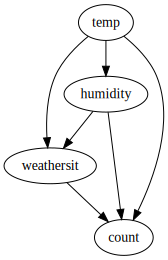

In [43]:
from causalgraphicalmodels import CausalGraphicalModel
causal = CausalGraphicalModel(
    nodes = ['temp', 'humidity', 'weathersit', 'count'],
    edges = [('temp', 'humidity'),
            ('temp', 'weathersit'),
            ('temp', 'count'),
            ('humidity', 'weathersit'),
            ('humidity', 'count'),
            ('weathersit', 'count')])
causal.draw()

We must make a few assumptions first before carrying out 2SLS analysis.

- Our instrumental variables are uncorrelated with noise of y. 

- Instrumental variables should be strongly correlated with explanatory variables.

The first assumption is not so readily testable in this case as we do not know the true population distribution by which we might approximate such a noise term.  We'd need population data, but if we are to assume the data we have is representative of the population behavior we can well reason that humidity is not linearly related to the number of riders for a given day. 


The second assumption however can be easily checked and observed for our temp explanatory variable.  But what it's not our instrumental variable's relationship with either of the individual explanatory variables but whether the combination of temp and weathersit are correlated with hum which would make a great deal of sense here. 

### 4.1.2 2 Stage Least Squares

To put this process more simply, we are seeking to estimate the impact of weather condition (weathersit) on daily rider count but it's something we can't pull and directly interpret from a linear regression intercept because we've also fit on temp.  We have highly correlated explanatory variables which gives us model intercepts which do not represent the true causal relationship we hope to pull out.  So we estimate our weathersit variable with our hum variable, by predicting weathersit from hum and temp.  We use this "predicted" weathersit as our weathersit in the original model.  So in the end we're regressing rider count onto "predicted" weathersit and temp.

In [44]:
import statsmodels.api as sm
stage1_features = np.concatenate([np.array(day['hum']).reshape(-1, 1), np.array(day['temp']).reshape(-1, 1)], axis = 1)
stage1_features_w_const = sm.add_constant(stage1_features)
stage1_ols = sm.OLS(np.array(day['weathersit']).reshape(-1, 1), stage1_features_w_const)
stage1_ols_results = (stage1_ols.fit()).params

weathersit_pred = stage1_ols_results * stage1_features_w_const

stage2_features = np.concatenate([np.array(np.sum(weathersit_pred, axis = 1)).reshape(-1, 1), np.array(day['temp']).reshape(-1, 1)], axis = 1)
stage2_features_w_const = sm.add_constant(stage2_features)
stage2_model = sm.OLS(np.array(day['cnt']).reshape(-1, 1), stage2_features_w_const)
stage2ols_results = (stage2_model.fit()).params

In [45]:
stage2ols_results[1]

-1057.2981644680535

Here our treatment effect of weathersit on the total number of rentals is -1057 which means that with each value of increase of weathersit we expect an average decrease of -1057 total riders.

In [46]:
# run for both casual and registered users
# registered
stage1_features = np.concatenate([np.array(day['hum']).reshape(-1, 1), np.array(day['temp']).reshape(-1, 1)], axis = 1)
stage1_features_w_const = sm.add_constant(stage1_features)
stage1_ols = sm.OLS(np.array(day['weathersit']).reshape(-1, 1), stage1_features_w_const)
stage1_ols_results = (stage1_ols.fit()).params

weathersit_pred = stage1_ols_results * stage1_features_w_const

stage2_features = np.concatenate([np.array(np.sum(weathersit_pred, axis = 1)).reshape(-1, 1), np.array(day['temp']).reshape(-1, 1)], axis = 1)
stage2_features_w_const = sm.add_constant(stage2_features)
stage2_model = sm.OLS(np.array(day['registered']).reshape(-1, 1), stage2_features_w_const)
stage2ols_results = (stage2_model.fit()).params

reg = stage2ols_results[1]

# casual 
stage1_features = np.concatenate([np.array(day['hum']).reshape(-1, 1), np.array(day['temp']).reshape(-1, 1)], axis = 1)
stage1_features_w_const = sm.add_constant(stage1_features)
stage1_ols = sm.OLS(np.array(day['weathersit']).reshape(-1, 1), stage1_features_w_const)
stage1_ols_results = (stage1_ols.fit()).params

weathersit_pred = stage1_ols_results * stage1_features_w_const

stage2_features = np.concatenate([np.array(np.sum(weathersit_pred, axis = 1)).reshape(-1, 1), np.array(day['temp']).reshape(-1, 1)], axis = 1)
stage2_features_w_const = sm.add_constant(stage2_features)
stage2_model = sm.OLS(np.array(day['casual']).reshape(-1, 1), stage2_features_w_const)
stage2ols_results = (stage2_model.fit()).params

cas = stage2ols_results[1]

In [47]:
reg

-753.9191450730071

In [48]:
cas

-303.3790193950465

For registered riders we expect an average decrease of -753 riders for each increase in weathersit, and for casual riders we expect an average decrease of -303 riders for each increase in weathersit.

### 4.1.3 Discussion

We wanted the measure the causal effect of our weathersit variable on the overall daily counts of riders as well as registered and casual riders.  We performed 2SLS using humidity as our instrumental variable along with temp to "predict" weathersit.  After regressing rider count on temperature and our predicted weathersit we found a treatment effect of -1057 for weathersit.  For each increase in the value of weathersit we expect on average -1057 riders.

When breaking down the treatment effect from the overall count to the registered and casual groups we see that the effect is much larger in magnitude for the registered set versus the casual set (-753 v -303).  This is because there are simply more registered riders each day.  It doesn't mean that registered riders are any more less likely to ride in more adverse weather versus casual riders, they simply represent a greater share of the overall rider population so the raw rider decrease will be greater on their side.

The graph from above still represents a useful model for this problem but there are a number of missing variables that we would greatly benefit from having. 

While we are accounting for weather in our causal graph we would also be helped out if we had ground truth estimates of the number of commuters or other variables that indicate to us the group of riders who will ride no matter what the weather conditions are.  

If I wanted to test the effect of adverse weather on the number of rentals I would first want to parse out the number of "dedicated" riders who simply will ride in any weather condition.  Maybe this is information I could get from surveying samples of the registered population, or I look for the individual riders who already display consistent usage in nearly all weather types.  If we can pin down this subset of riders we can exclude them from our causal analysis and run a more accurate assessment of the causal effects of weathersit.

In [71]:
ny_daily.to_csv('ny_daily.csv')
chi_daily.to_csv('chi_daily.csv')
dc_daily.to_csv('dc_daily.csv')